<center>

EcoCommons GitHub Notebooks ![EcoCommons](https://www.ecocommons.org.au)
    
</center>


# EcoCommons Notebook 
## Species Distribution Analysis
### Genralised Linear Model (GLM) 


---
Author details: EcoCommons team 2024?
Editor details:     
Contact details: support@ecocommons.org.au 
Copyright statement: This script is the product of the EcoCommons platform.   
                     Please refer to the EcoCommons website for more details:   
                     <https://www.ecocommons.org.au/>  
Date: August 2024  

---

#### Script and data info: 

This notebook provides an example of how to run a simple version SDM.

In the near future, this material may form part of comprehensive support materials available to EcoCommons users.
 
If you have any corrections or suggestions to improve the effeciengy, please [contact the EcoCommons](mailto:support@ecocommons.org.au) support and communications team.

In [13]:
# Some House keeping Before we start

# Set Workspace as the current working directory
Workspace <- getwd() 
#Workspace <- "/DIR"      #change directory

#The cat function in useful for displaying messages and debugging information.
cat("Workspace:", Workspace, "\n")

# Create the 'raw_data' directory within the current and parent working directory
dir.create(file.path(Workspace, "raw_data"), recursive = TRUE)

# supress warnings
options(warn= -1)

# specify the packages of interest
packages <- c("dismo", "ggplot2", "raster", "googledrive", "sp", "dplyr")
install.packages(packages)
lapply(packages, require, character.only = TRUE)


# now load all or install&load all from CRAN
package.check <- lapply(
  packages,
  FUN = function(x) {
    if (!require(x, character.only = TRUE)) {
      install.packages(x, dependencies = TRUE)
      library(x, character.only = TRUE)
    }
  }
)

search()

Workspace: /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1.GithubRepo/notebooks/notebooks/Species_Distribution_Modelling 



The downloaded binary packages are in
	/var/folders/t0/9dty7yc10v91d98_j_6hqpj00000gn/T//RtmpF5M5vM/downloaded_packages


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[1] ".GlobalEnv"          "package:terra"       "package:dplyr"      
 [4] "package:googledrive" "package:ggplot2"     "package:dismo"      
 [7] "package:raster"      "package:sp"          "jupyter:irkernel"   
[10] "package:stats"       "package:graphics"    "package:grDevices"  
[13] "package:utils"       "package:datasets"    "package:methods"    
[16] "Autoloads"           "package:base"

In [3]:
# De-authenticate to access public files
drive_deauth()

# Google Drive file IDs
csv_file_id <- "1mNBJAwhCiJzliAqAPWqBJf6qQ6KP11jH"   #https://drive.google.com/file/d/1mNBJAwhCiJzliAqAPWqBJf6qQ6KP11jH/view?usp=drive_link
grd_file_id <- "1IDrfCzAyf3C3QYs6EhTCU8gsaIsmVbWV"    #https://drive.google.com/file/d/1IDrfCzAyf3C3QYs6EhTCU8gsaIsmVbWV/view?usp=drive_link
gri_file_id <- "106fNjf5VaAdue9Q02BghXZeLqPM7qCYm"     #https://drive.google.com/file/d/106fNjf5VaAdue9Q02BghXZeLqPM7qCYm/view?usp=drive_link

# Download the CSV and spatial files  to the 'raw_data' directory
drive_download(as_id(csv_file_id), path = file.path(Workspace, "raw_data", "tree_kangaroo.csv"), overwrite = TRUE)
drive_download(as_id(grd_file_id), path = file.path(Workspace, "raw_data", "env_current.grd"), overwrite = TRUE)
drive_download(as_id(gri_file_id), path = file.path(Workspace, "raw_data", "env_forecast.gri"), overwrite = TRUE)

# Confirm the files have been downloaded
list.files(file.path(Workspace, "raw_data"))

File downloaded:

* Tree_kangaroo.csv <id:<U+00A0>1mNBJAwhCiJzliAqAPWqBJf6qQ6KP11jH>

Saved locally as:

* /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/tree_kangaroo.csv

File downloaded:

* env_current.grd <id:<U+00A0>1IDrfCzAyf3C3QYs6EhTCU8gsaIsmVbWV>

Saved locally as:

* /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/env_current.grd

File downloaded:

* env_forecast.gri <id:<U+00A0>106fNjf5VaAdue9Q02BghXZeLqPM7qCYm>

Saved locally as:

* /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/env_forecast.gri



[1] "env_current.grd"   "env_forecast.gri"  "tree_kangaroo.csv"

In [10]:
#packages for the analysis

library(dismo)
library(dplyr)
library(ggplot2)
library(raster)


also installing the dependencies 'gargle', 'httr'





The downloaded binary packages are in
	/var/folders/t0/9dty7yc10v91d98_j_6hqpj00000gn/T//RtmpbmgaLW/downloaded_packages


In [5]:
#read occurance data
tree_kangaroo_data <-read.csv("/Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/tree_kangaroo.csv")
#check data class
sapply(tree_kangaroo_data, class)
#change data class to numeric
tree_kangaroo_data <- tree_kangaroo_data %>% mutate(across(where(is.character), as.numeric))
#check again
sapply(tree_kangaroo_data, class)
#assign CRS



species         lat         lon     present 
"character" "character" "character"   "integer"

species       lat       lon   present 
"numeric" "numeric" "numeric" "integer"

In [8]:
env_data_current <-stack("/Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/env_current.grd")
env_data_forecast <-stack("/Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/env_forecast.gri")

ERROR: Error in .rasterObjectFromFile(x, objecttype = "RasterBrick", ...): Cannot create a RasterLayer object from this file.


In [11]:
library(terra)

env_data_current <- rast("/Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/env_current.grd")
env_data_forecast <- rast("/Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/env_forecast.gri")

env_stack_current <- app(env_data_current, fun = stack)
env_stack_forecast <- app(env_data_forecast, fun = stack)


terra 1.7.78



ERROR: Error: [rast] cannot open this file as a SpatRaster: /Users/qcifecocommons/Library/CloudStorage/OneDrive-QueenslandCyberInfrastructureFoundationLtd/1. GithubRepo/notebooks/notebooks/Species Distribution Modelling/raw_data/env_current.grd


In [9]:
plot(env_data_current$tmin)
plot(env_data_current$precip)
plot(env_data_forecast$tmin)
plot(env_data_forecast$precip)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'plot': object 'env_data_current' not found


In [2]:
tk_locations <- select(tree_kangaroo_data,lon,lat)
tk_env <-extract(env_data_current,tk_locations)
tree_kangaroo_data <- cbind(tree_kangaroo_data, tk_env)



ERROR: Error in eval(expr, envir, enclos): object 'tree_kangaroo_data' not found


In [112]:
# Check CRS

crs(env_data_current)
crs(tk_locations)

Coordinate Reference System:
Deprecated Proj.4 representation:
 +proj=longlat +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +no_defs 
WKT2 2019 representation:
BOUNDCRS[
    SOURCECRS[
        GEOGCRS["unknown",
            DATUM["World Geodetic System 1984",
                ELLIPSOID["WGS 84",6378137,298.257223563,
                    LENGTHUNIT["metre",1]],
                ID["EPSG",6326]],
            PRIMEM["Greenwich",0,
                ANGLEUNIT["degree",0.0174532925199433],
                ID["EPSG",8901]],
            CS[ellipsoidal,2],
                AXIS["longitude",east,
                    ORDER[1],
                    ANGLEUNIT["degree",0.0174532925199433,
                        ID["EPSG",9122]]],
                AXIS["latitude",north,
                    ORDER[2],
                    ANGLEUNIT["degree",0.0174532925199433,
                        ID["EPSG",9122]]]]],
    TARGETCRS[
        GEOGCRS["WGS 84",
            DATUM["World Geodetic System 1984",
                ELLIPSOID[

[1] NA

Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_point()`)."


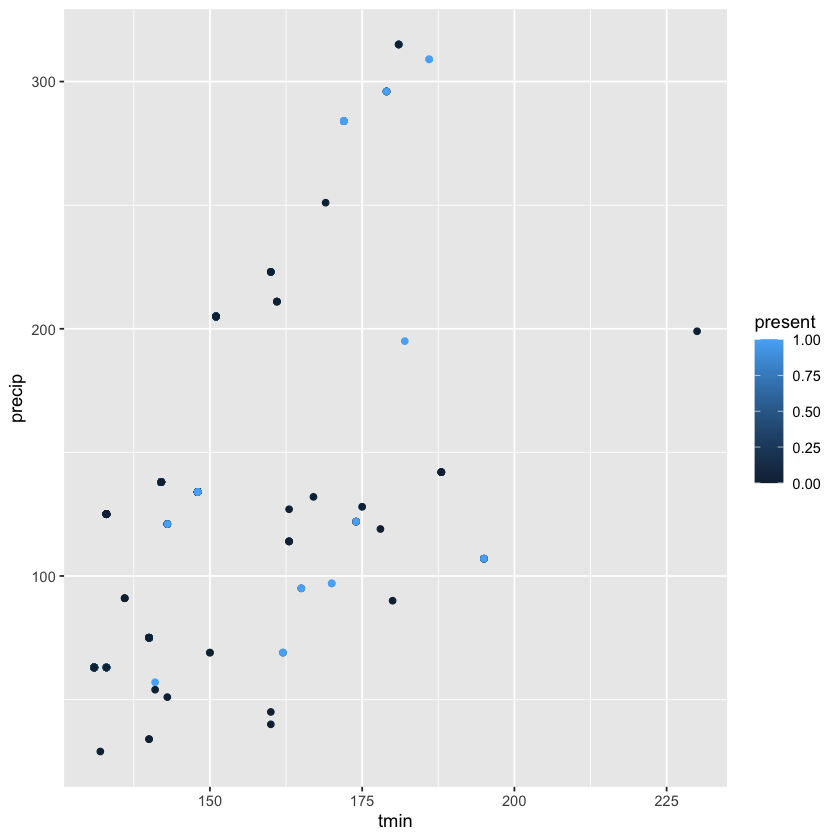

In [113]:
ggplot(tree_kangaroo_data, 
       mapping = aes(x =tmin,y = precip, color = present)) +
  geom_point()

In [114]:
#GLM
#multivariate ligistic regression
#Occurance on X & envir on Y
#Probability low or high for multiple variables

logistic_regr_model <- glm(present ~ tmin + precip,
                           family = binomial(link = "logit"),
                           data = tree_kangaroo_data)
summary(logistic_regr_model)


Call:
glm(formula = present ~ tmin + precip, family = binomial(link = "logit"), 
    data = tree_kangaroo_data)

Coefficients:
             Estimate Std. Error z value Pr(>|z|)  
(Intercept) -1.925655   1.099357  -1.752   0.0798 .
tmin         0.006446   0.008475   0.761   0.4469  
precip       0.001007   0.001951   0.516   0.6058  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 864.30  on 707  degrees of freedom
Residual deviance: 862.23  on 705  degrees of freedom
  (1 observation deleted due to missingness)
AIC: 868.23

Number of Fisher Scoring iterations: 4


# Model evaluation

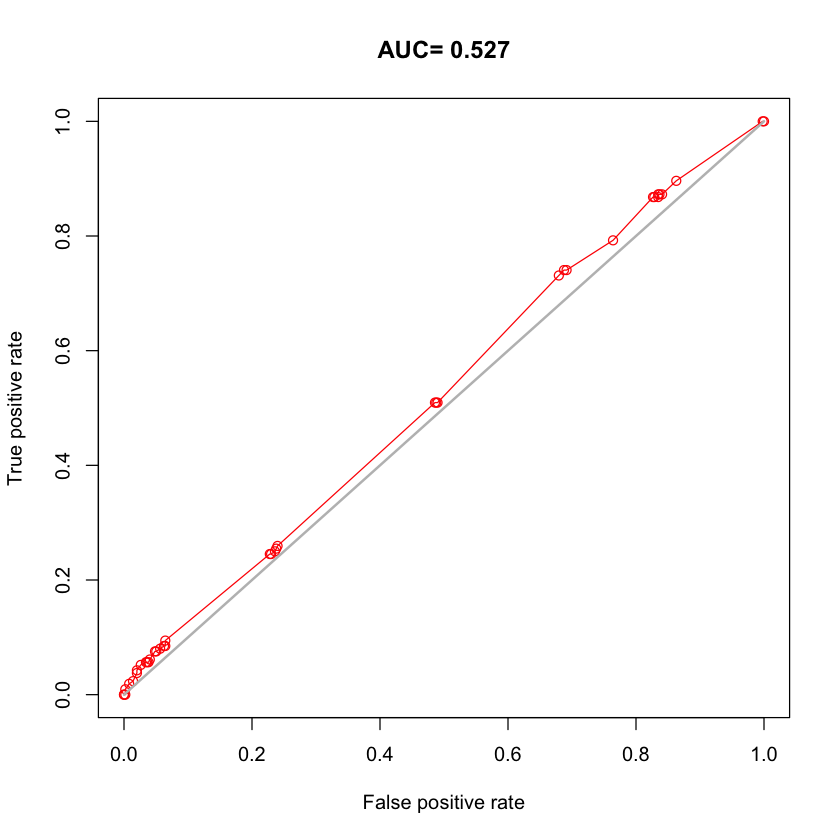

In [115]:
presence_data <-filter(tree_kangaroo_data,present ==1)
absence_data <-filter(tree_kangaroo_data,present ==0)

evaluation = evaluate(presence_data,absence_data,logistic_regr_model)
plot(evaluation,"ROC")

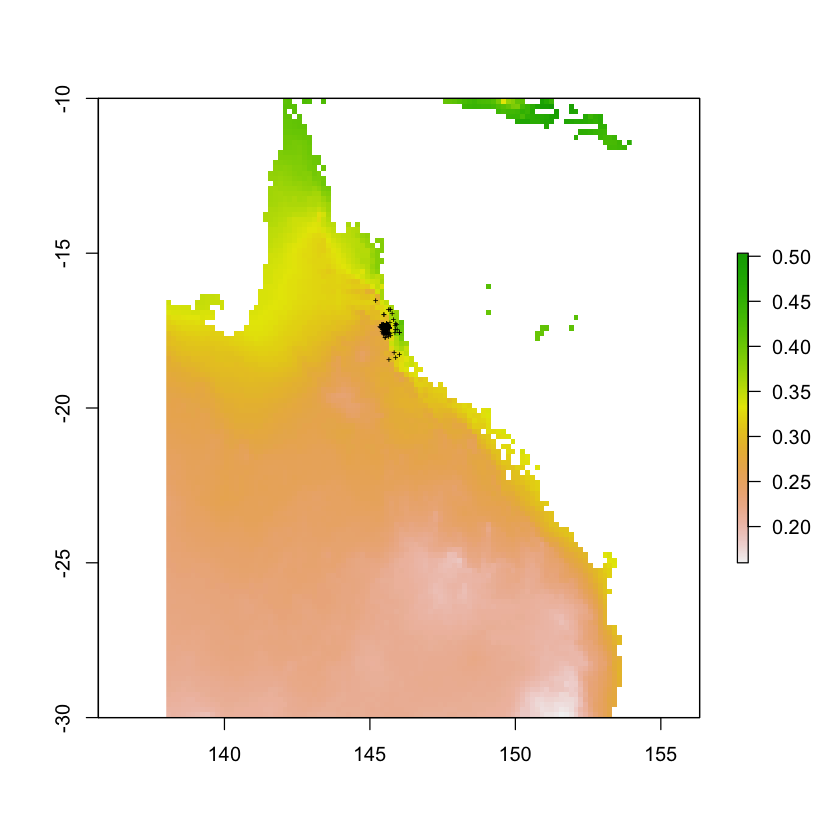

In [116]:
#absence from large scales can be problematic


predictions = predict(env_data_current,
                      logistic_regr_model,
                      type = "response") 
plot(predictions, ext = extent(138, 154, -30, -10))

points(presence_data[c("lon","lat")],pch ="+", cex = 0.5)



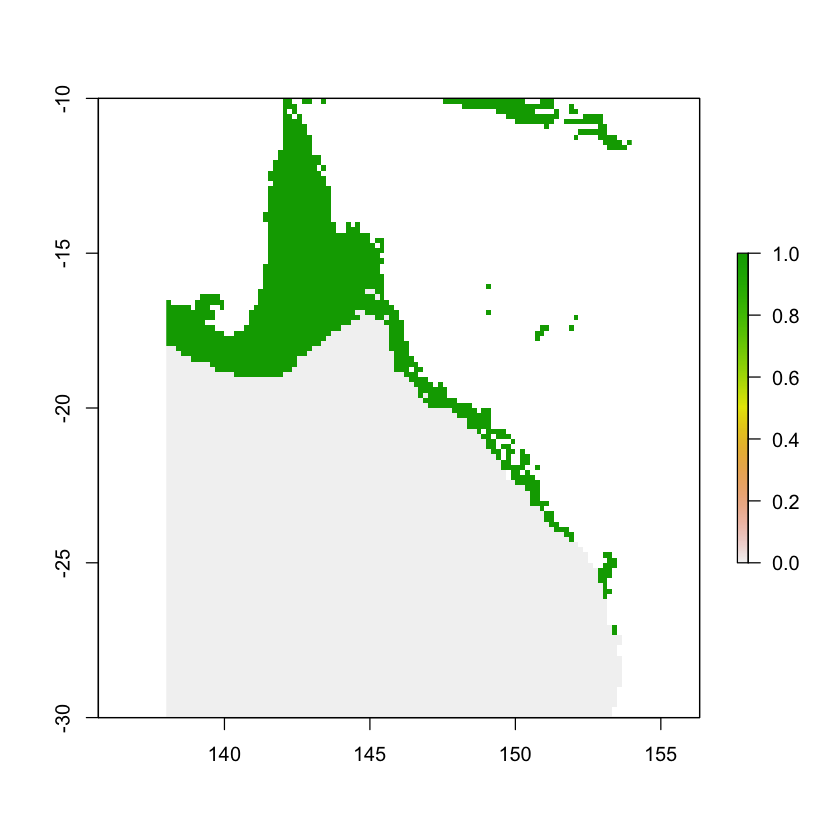

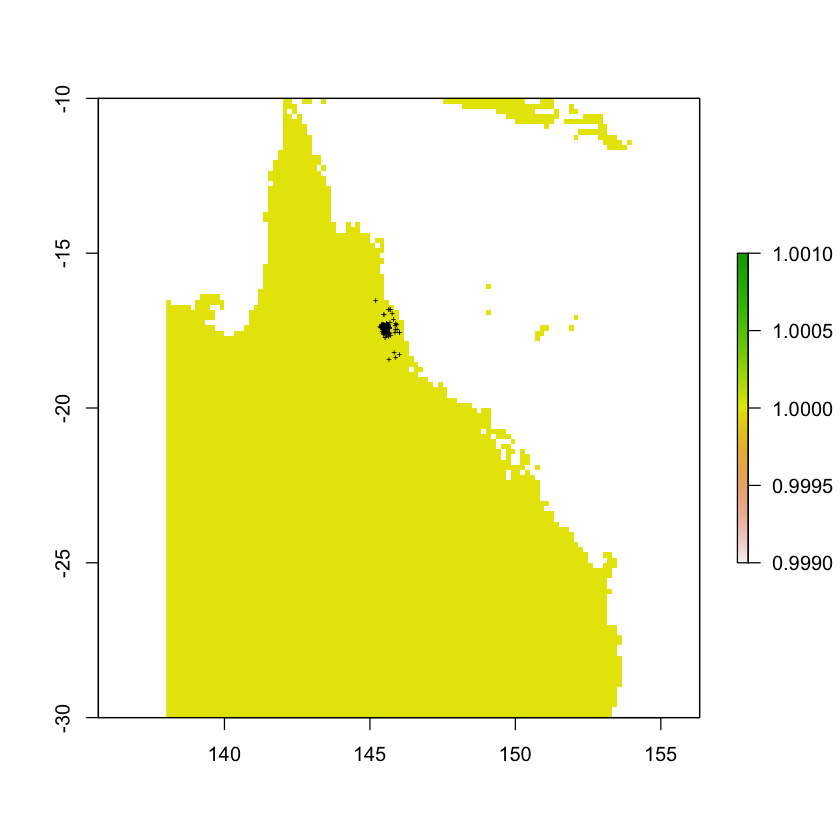

In [117]:
#40% threshold
plot(predictions>0.3, ext =extent(138, 154, -30, -10))
# Calculate the threshold
tr <- threshold(evaluation, stat = "prevalence")
# Plot the predictions with the specified threshold and extent
plot(predictions > tr, ext = extent(138, 154, -30, -10))
points(presence_data[c("lon", "lat")], pch = "+", cex = 0.5)


In [118]:
str(env_data_forecast)
summary(env_data_forecast)
summary(env_data_current)
model_vars <- names(coef(logistic_regr_model))
missing_vars <- setdiff(model_vars, names(env_data_forecast))

if (length(missing_vars) > 0) {
  print(paste("Missing variables in env_data_forecast:", paste(missing_vars, collapse = ", ")))
}


Formal class 'RasterStack' [package "raster"] with 12 slots
  ..@ filename: chr ""
  ..@ layers  :List of 2
  .. ..$ :Formal class 'RasterLayer' [package "raster"] with 13 slots
  .. .. .. ..@ file    :Formal class '.RasterFile' [package "raster"] with 13 slots
  .. .. .. .. .. ..@ name        : chr "/Users/qcifecocommons/Documents/RDIR/wd4liteSDM/sdm_data/env_forecast.grd"
  .. .. .. .. .. ..@ datanotation: chr "FLT4S"
  .. .. .. .. .. ..@ byteorder   : Named chr "little"
  .. .. .. .. .. .. ..- attr(*, "names")= chr "value"
  .. .. .. .. .. ..@ nodatavalue : num -3.4e+38
  .. .. .. .. .. ..@ NAchanged   : logi FALSE
  .. .. .. .. .. ..@ nbands      : int 2
  .. .. .. .. .. ..@ bandorder   : Named chr "BIL"
  .. .. .. .. .. .. ..- attr(*, "names")= chr "value"
  .. .. .. .. .. ..@ offset      : int 0
  .. .. .. .. .. ..@ toptobottom : logi TRUE
  .. .. .. .. .. ..@ blockrows   : int 0
  .. .. .. .. .. ..@ blockcols   : int 0
  .. .. .. .. .. ..@ driver      : chr "raster"
  .. .. .. .

Warning message in .local(object, ...):
"summary is an estimate based on a sample of 1e+05 cells (5.14% of all cells)
"


,tmin,precip
Min.,-187,0
1st Qu.,12,15
Median,100,36
3rd Qu.,199,69
Max.,330,1039
NA's,1356387,1356387


Warning message in .local(object, ...):
"summary is an estimate based on a sample of 1e+05 cells (5.14% of all cells)
"


,tmin,precip
Min.,-223,0
1st Qu.,-19,14
Median,72,34
3rd Qu.,170,67
Max.,289,879
NA's,1356387,1356387


[1] "Missing variables in env_data_forecast: (Intercept)"


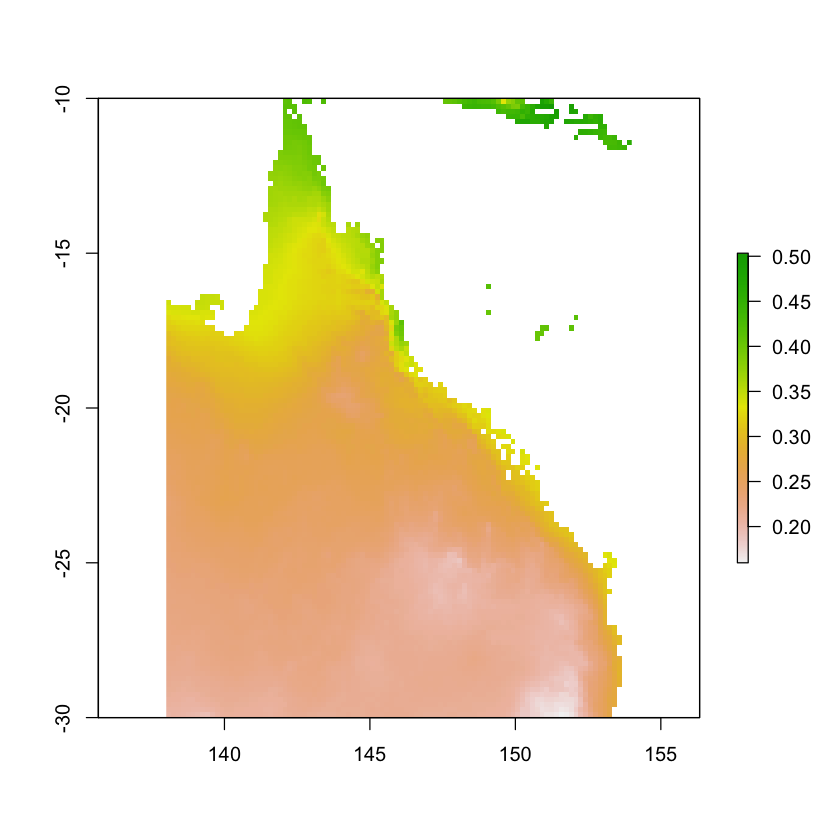

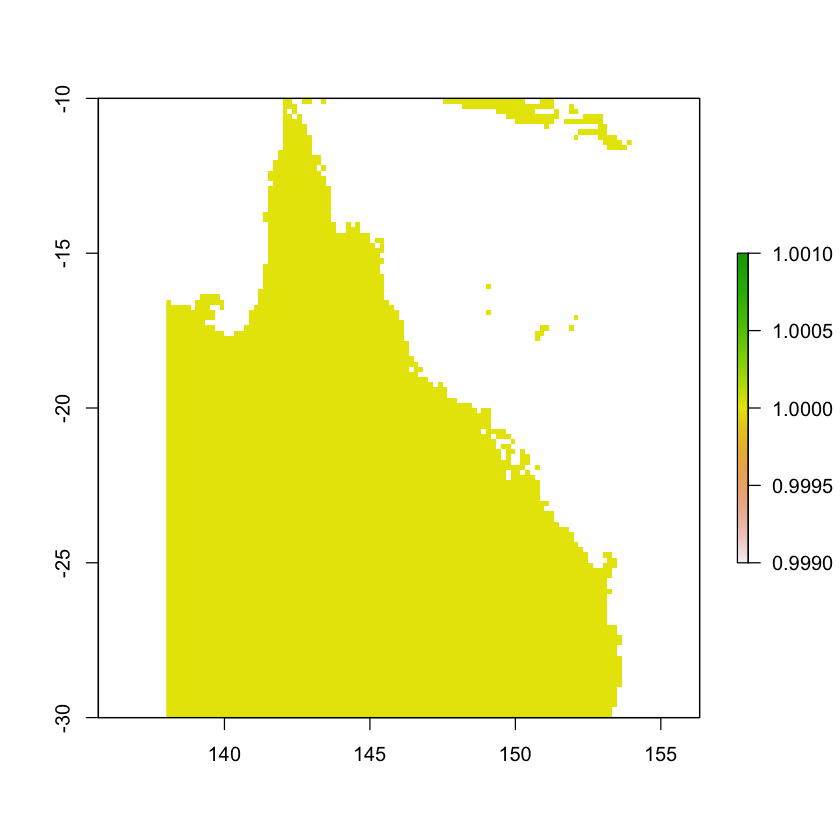

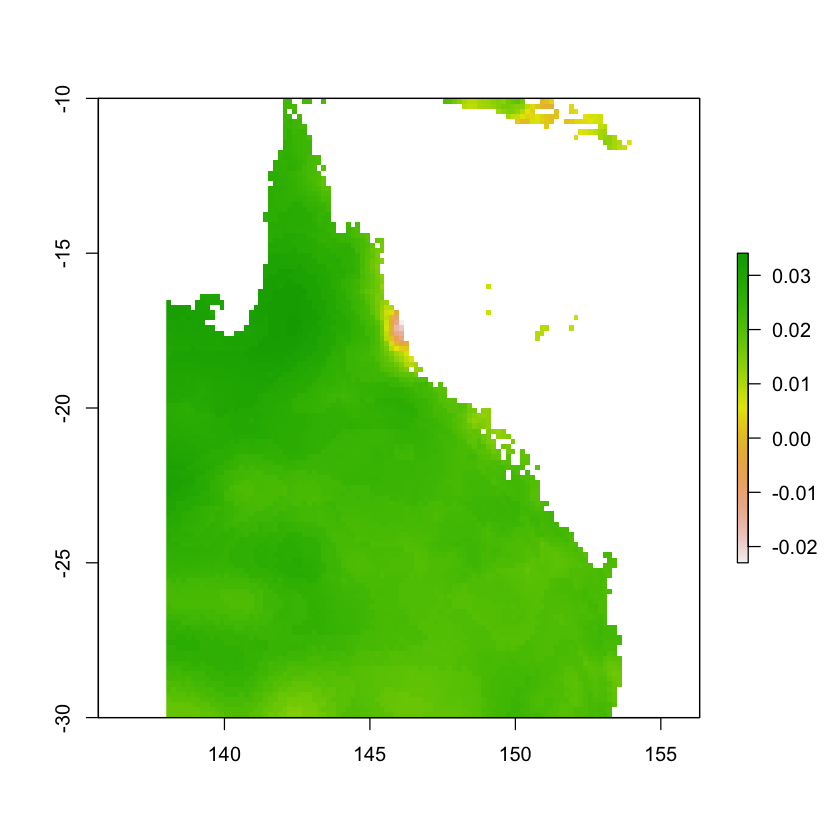

In [119]:
#future

forecasts = predict(env_data_forecast,
                    logistic_regr_model
                    ,type = "response")
extent_values <- extent(138, 154, -30, -10)
plot(predictions, ext = extent_values)
plot(forecasts > tr, ext = extent(138, 154, -30, -10))
plot(forecasts - predictions, ext = extent(138, 154, -30, -10))

